In [1]:
!which python

/lfs/skampere1/0/kaif/conda/envs/TheoremSense/bin/python


In [1]:
from dataset import load_datasets, BOXED_ANSWERS_DATASETS

In [2]:
%%capture
datasets = load_datasets(BOXED_ANSWERS_DATASETS);

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6,7"

from vllm import LLM, SamplingParams

In [4]:
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=512, logprobs=100)

In [5]:
# model_name = "EleutherAI/llemma_7b"
model_name = "llm-agents/tora-13b-v1.0"
# model_name = "deepseek-ai/deepseek-math-7b-rl"
# pipeline = pipeline('text-generation', model=model_name, device=0, max_length=2048)
llm = LLM(model=model_name, trust_remote_code=True)

INFO 02-29 10:39:22 llm_engine.py:79] Initializing an LLM engine with config: model='llm-agents/tora-13b-v1.0', tokenizer='llm-agents/tora-13b-v1.0', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)
INFO 02-29 10:39:25 weight_utils.py:163] Using model weights format ['*.bin']
INFO 02-29 10:39:39 llm_engine.py:337] # GPU blocks: 3784, # CPU blocks: 327
INFO 02-29 10:39:40 model_runner.py:676] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 02-29 10:39:40 model_runner.py:680] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decrea

In [7]:
from prompt import generate_nshot_prompts

In [7]:
def generate_nshot_prompts(dataset, n: int | list[int] = 5):
    """
    Generate n-shot prompts for a given dataset.

    :param dataset: A list of dictionaries, each containing a question and answer.
    :param n: The number of examples to include in the prompt. If an integer, the first n examples will be included.
              If a list, the examples at the given indices will be included.
    :return: A list of (prompt, answer) tuples.
    """
    n = list(range(n)) if isinstance(n, int) else n
    few_shot_count = len(n)
    prompt_examples = [dataset[i] for i in n]
    remaining_examples = [ex for i, ex in enumerate(dataset) if i not in n]

    prompt_header = f'Answer the following {few_shot_count + 1} questions:\n\n'
    prompt_header += '\n'.join([f'{i+1}. {ex["question"]}\n\n{ex["answer"]}\n\n' for i, ex in enumerate(prompt_examples)])
    # prompt_header += '\n'.join([f'{ex["question"]}\n\n{ex["answer"]}\n\n' for ex in prompt_examples])

    return [(
        prompt_header + f'\n{few_shot_count + 1}. {ex["question"]}',
        ex["answer"],
        ex["boxed"]
    ) for ex in remaining_examples]

dataset = datasets[0]
data_3shot = generate_nshot_prompts(list(dataset['data']['train']), 3)

In [21]:
from torch.nn import CrossEntropyLoss
import torch
import numpy as np

def perplexity(outputs):
    if not isinstance(outputs, list):
        outputs = [outputs]

    ppls = []
    loss_fn = CrossEntropyLoss(reduction='none')
    for o in outputs:
        # o.logprobs is a dict from token ids to log probabilities
        # o.token_ids is a sequence of tokens
        # create a tensor of token ids of shape (seq_len, k)
        # ensure that the target tokens are the first tokens in the logprobs array
        assert [list(v.keys())[0] for v in o.logprobs] == o.token_ids
        
        
        logprobs = [list(v.values()) for v in o.logprobs]
        # pad logprobs with -inf to ensure that the tensor is of shape (seq_len, k)
        max_len = max(len(l) for l in logprobs)
        logprobs = [l + [-float('inf')] * (max_len - len(l)) for l in logprobs]
        logprobs = torch.tensor(logprobs)
        
        ppl = np.exp(np.mean(loss_fn(logprobs, torch.zeros(logprobs.shape[0], dtype=torch.long)).tolist()))
        ppls.append(ppl)
    
        # lls += [loss_fn(logprobs, torch.zeros(logprobs.shape[0], dtype=torch.long)).tolist()]
    
    return ppls
    # print(len(lls))
    # print(len(lls[0]))
    # return np.exp(np.mean(lls, axis=1))


In [87]:
dir(llm.llm_engine.tokenizer._tokenizer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getnewargs__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'add_special_tokens',
 'add_tokens',
 'decode',
 'decode_batch',
 'decoder',
 'enable_padding',
 'enable_truncation',
 'encode',
 'encode_batch',
 'encode_special_tokens',
 'from_buffer',
 'from_file',
 'from_pretrained',
 'from_str',
 'get_added_tokens_decoder',
 'get_vocab',
 'get_vocab_size',
 'id_to_token',
 'model',
 'no_padding',
 'no_truncation',
 'normalizer',
 'num_special_tokens_to_add',
 'padding',
 'post_process',
 'post_processor',
 'pre_tokenizer',
 'save',
 'to_str',
 'token_to_id',
 'train',
 'train_from_iterator',
 'truncation']

In [126]:
??llm.llm_engine.tokenizer.convert_tokens_to_string
#("hello world. This is a test.")

In [134]:
str = "hello world. This is a test. \\frac{1}{2}@"
llm.llm_engine.tokenizer(str), llm.llm_engine.tokenizer.convert_ids_to_tokens(llm.llm_engine.tokenizer.encode(str, add_special_tokens=False))

({'input_ids': [100000, 31539, 1843, 13, 1002, 317, 245, 1727, 13, 357, 1122, 90, 16, 1061, 17, 92, 31], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 ['hello',
  'Ġworld',
  '.',
  'ĠThis',
  'Ġis',
  'Ġa',
  'Ġtest',
  '.',
  'Ġ\\',
  'frac',
  '{',
  '1',
  '}{',
  '2',
  '}',
  '@'])

In [204]:
# Avg token accuracy
# The average per-token accuracy is calculated for a ground truth answer (t1,...,tn) by averaging the accuracies (i.e. 1 if the highest-probability token predicted by the model conditioned on (t1,...,tk) matches the ground truth for all 1 <= k <= {n-1}).
# teacher forcing style
import numpy as np

def generate_teacher_forced_prompts(prompt, solution):
    """
    Generate teacher-forced prompts for a given prompt and solution.
    
    :param prompt: The prompt to use.
    :param solution: The solution to use.
    :return: A list of prompts, each with one additional token from the solution, and the end position of the prefix in the solution.
    """
    prefix_pos = len(llm.llm_engine.tokenizer.encode(prompt)) - 1
    token_ids = llm.llm_engine.tokenizer.encode(solution, add_special_tokens=False)
    solution_tokens = llm.llm_engine.tokenizer.convert_ids_to_tokens(token_ids)
    # get cumulative sum of lengths of tokens
    prompt_lengths = np.cumsum([0] + [len(t) for t in solution_tokens])
    assert prompt_lengths[-1] == len(solution)
    prompts = [prompt + solution[:prompt_lengths[i]] for i in range(len(prompt_lengths[:-1]))]
    return prompts, token_ids, prefix_pos
    
    

def teacher_forcing_accuracy(prompt, solution, model, debug=False):
    """
    Calculate the average per-token accuracy for a given prompt and solution using teacher forcing.
    
    :param prompt: The prompt to use.
    :param solution: The solution to use.
    :param model: The model to use.
    :param debug: Whether to print debug information (predicted vs ground truth tokens for each token in the solution)
    :return: The average per-token accuracy.
    """
    prompts, token_ids, prefix_pos = generate_teacher_forced_prompts(prompt, solution)
    sampling_params = SamplingParams(temperature=0, top_p=0.95, max_tokens=1)
    outputs = model.generate(prompts, sampling_params, use_tqdm=False)
    accuracies = []
    for i, o in enumerate(outputs):
        # get the token id of the predicted token
        pred_token_id = o.outputs[0].token_ids[0]
        # get the token id of the correct token
        correct_token_id = token_ids[i]
        # check if the predicted token is correct
        accuracies.append(int(pred_token_id == correct_token_id))
        if debug:
            print(f"Predicted:\t\"{llm.llm_engine.tokenizer.convert_ids_to_tokens([pred_token_id])[0]}\"")
            print(f"Correct:\t\"{llm.llm_engine.tokenizer.convert_ids_to_tokens([correct_token_id])[0]}\"")
        
    return np.mean(accuracies)

In [211]:
??llm.generate

In [198]:
# test teacher forcing accuracy
prompt = "What is the value of x in the equation x + 3 = 7?\n"
solution = "Answer: x = 4"
teacher_forcing_accuracy(prompt, solution, llm, debug=True)

Processed prompts: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 194.41it/s]

Predicted:	"A"
Correct:	"Answer"
Predicted:	":"
Correct:	":"
Predicted:	"ĠTo"
Correct:	"Ġx"
Predicted:	"Ġ="
Correct:	"Ġ="
Predicted:	"Ġ"
Correct:	"Ġ"
Predicted:	"4"
Correct:	"4"


0.6666666666666666

In [205]:
# compute teacher forcing accuracy for all examples
from tqdm import tqdm
accuracies = [teacher_forcing_accuracy(p, a, llm) for p, a, _ in tqdm(data_3shot[:100])]

100%|█████████████████████████████████████████████████████████████████████████| 100/100 [24:15<00:00, 14.55s/it]


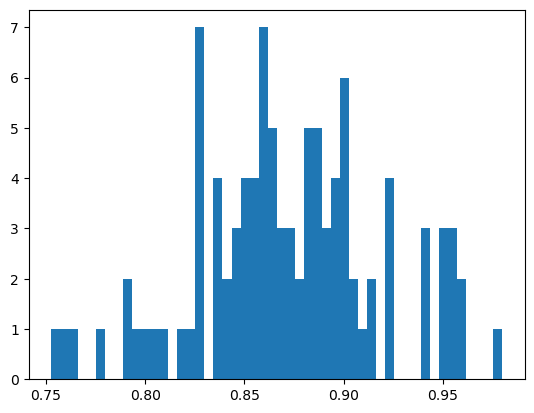

In [206]:
# plot histogram of accuracies
import matplotlib.pyplot as plt
plt.hist(accuracies, bins=50)
plt.show()

In [207]:
# grade the model
from grader import ExactMatchGrader
grader = ExactMatchGrader()

In [208]:
from dataset import get_boxed_answer
from latex_formater import latex_deformat

outputs = llm.generate([d[0] for d in data_3shot[:100]], sampling_params)

boxed_predictions = [latex_deformat(get_boxed_answer(o.outputs[0].text)) for o in outputs]
boxed_answers = [latex_deformat(d[2]) for d in data_3shot]
grades = grader.grade(boxed_predictions, boxed_answers)

Processed prompts: 100%|██████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.12it/s]


In [209]:
np.mean(grades)

0.34

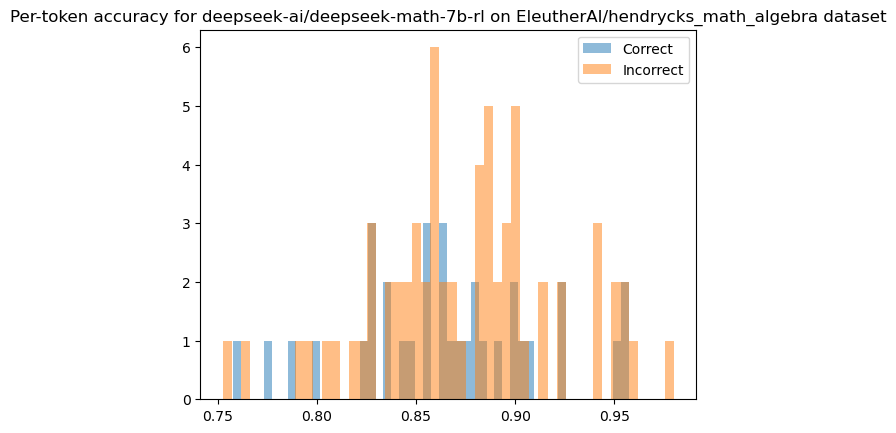

In [210]:
# plot histogram of accuracies for correct and incorrect answers
correct_idxs = np.where(np.array(grades) == 1)[0]
incorrect_idxs = np.where(np.array(grades) == 0)[0]
plt.hist([accuracies[i] for i in correct_idxs], bins=50, alpha=0.5, label='Correct')
plt.hist([accuracies[i] for i in incorrect_idxs], bins=50, alpha=0.5, label='Incorrect')
plt.legend()
plt.title(f'Per-token accuracy for {model_name} on {dataset["name"]} dataset')
plt.show()

In [9]:
# o = llm.generate([d[0] for d in data_3shot[:1]], sampling_params)[0].outputs[0]

Processed prompts: 100%|██████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


In [10]:
outputs = llm.generate([d[0] for d in data_3shot], sampling_params)

Processed prompts: 100%|████████████████████████████████████████████████████| 1741/1741 [10:48<00:00,  2.68it/s]


In [11]:
predictions = [o.outputs[0] for o in outputs]

In [22]:
ppl = perplexity(predictions)

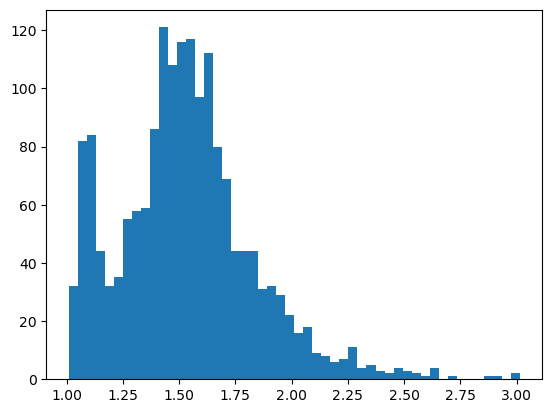

In [23]:
import matplotlib.pyplot as plt
# np.mean(perplexity(predictions[:1000]))
plt.hist(ppl, bins=50)
plt.show()

In [24]:
# save outputs to file
from pathlib import Path
import pickle
save_path = Path('~/generated_outputs') / dataset["name"].replace("/", "_") / f'{model_name.replace("/", "_")}.pkl'
save_path = save_path.expanduser()
save_path.parent.mkdir(parents=True, exist_ok=True)
if not save_path.exists():
    with open(save_path, 'wb') as f:
        pickle.dump(outputs, f)
else:
    print(f"File {save_path} already exists.")

In [8]:
# load outputs from file
with open(save_path, 'rb') as f:
    outputs = pickle.load(f)

In [25]:
from grader import ExactMatchGrader
grader = ExactMatchGrader()

In [26]:
from dataset import get_boxed_answer
from latex_formater import latex_deformat

boxed_predictions = [latex_deformat(get_boxed_answer(o.outputs[0].text)) for o in outputs]
boxed_answers = [latex_deformat(d[2]) for d in data_3shot]
grades = grader.grade(boxed_predictions, boxed_answers)

1/a
-5/2
(3/4)
-3/2
1/2
-5/3
45\pi/4
2\nabla5=127/75
28/7
13/3
-11/2
x^{1/3}=-1\pm\sqrt{5}
4/3
13/8
H/G=-5
(1/3,1)
\frac{9^{3/2}+7}{2}
8/3
5/9
3/a
12/7
-4/3
1/2
5/2
-1/8
13/12
12^{1/7}
-5/4
2/15


In [95]:
np.mean(grades)

0.3228029867892016

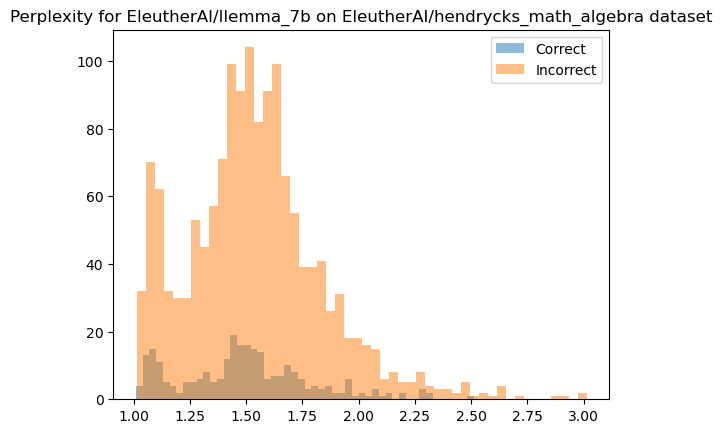

In [27]:
# plot ppl histogram for correct and incorrect answers
correct_idxs = np.where(np.array(grades) == 1)[0]
incorrect_idxs = np.where(np.array(grades) == 0)[0]
plt.hist([ppl[i] for i in correct_idxs], bins=50, alpha=0.5, label='Correct')
plt.hist([ppl[i] for i in incorrect_idxs], bins=50, alpha=0.5, label='Incorrect')
plt.legend()
plt.title(f'Perplexity for {model_name} on {dataset["name"]} dataset')
plt.show()

In [82]:
# use llm to check the outputs to see if they match the answers
few_shot_header = """Answer the following 3 questions:
Are the following two answers equivalent?
a) 7
b) 8
Reasoning: $7 \\neq 8$. The two answers are not equivalent.
Answer: No
Are the following two answers equivalent?
a) (x+1)^2
b) x^2+2x+1
Reasoning: Applying the distributive property, we have $(x+1)^2=x(x+1)+1(x+1)=x^2+2x+1$. The two answers are equivalent.
Answer: Yes
Are the following two answers equivalent?
"""
grading_prompts = [few_shot_header + f'a) {p}\nb) {a}\nReasoning: ' for p, a in zip(boxed_predictions, boxed_answers)]

In [83]:
grading_outputs = llm.generate(grading_prompts[:10], sampling_params)

Processed prompts: 100%|████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.33it/s]


In [91]:
i = 7
print(grading_outputs[i].prompt)
print('=' * 20)
print(grading_outputs[i].outputs[0].text)

Answer the following 3 questions:
Are the following two answers equivalent?
a) 7
b) 8
Answer: No
Are the following two answers equivalent?
a) (x+1)^2
b) x^2+2x+1
Answer: Yes
Are the following two answers equivalent?
a) 0
b) 0

Answer: No


In [33]:
import numpy as np
np.mean(grades)

0.2688110281447444

In [15]:
import numpy as np
np.mean(grades)

0.2716829408385985

In [12]:
import numpy as np
np.mean(grades)

0.2446869615163699

In [14]:
import numpy as np
np.mean(grades)

0.1372774267662263

In [34]:
# compute edit distance between predictions and answers
from Levenshtein import distance
distances = [distance(p, a) / max(len(p), len(a)) for p, a in zip(boxed_predictions, boxed_answers)]

In [33]:
idxs = np.argsort(distances)
for i in idxs[600:610]:
    print(f"Distance: {distances[i]}")
    print(f"Prediction: {boxed_predictions[i]}")
    print(f"Answer: {boxed_answers[i]}")
    print('=' * 20)

Distance: 2
Prediction: -1
Answer: 18
Distance: 2
Prediction: 25
Answer: 14
Distance: 2
Prediction: 
Answer: 16
Distance: 2
Prediction: 
Answer: 27
Distance: 2
Prediction: 
Answer: 15
Distance: 2
Prediction: 
Answer: 26
Distance: 2
Prediction: 2
Answer: 16
Distance: 2
Prediction: 16
Answer: 21
Distance: 2
Prediction: -2
Answer: 6
Distance: 2
Prediction: x=4
Answer: 4


(array([239.,   0.,   1.,   1.,   1.,   2.,   1.,   7.,   3.,   5.,   2.,
          5.,  17.,   3.,   6.,  11.,  24.,   3.,   5.,   3.,  10.,   2.,
          2.,   1.,   0., 109.,   2.,   5.,   3.,   2.,  14.,   5.,   4.,
         76.,   1.,  11.,   4.,  33.,   5.,   1.,  24.,  22.,  14.,  11.,
          9.,  39.,  35.,  26.,  11., 921.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

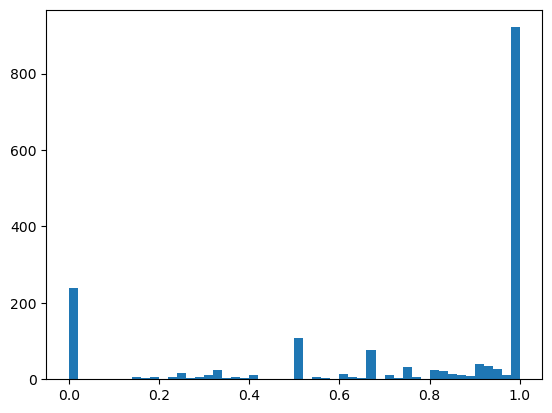

In [35]:
# plot histogram of distances
import matplotlib.pyplot as plt
plt.hist(distances, bins=50)

In [31]:
i=6
print(outputs[i].prompt)
print('=' * 20)
print(outputs[i].outputs[0].text)
print('=' * 20)
print(data_3shot[i][1])

Answer the following 4 questions:

1. Let \[f(x) = \left\{
\begin{array}{cl} ax+3, &\text{ if }x>2, \\
x-5 &\text{ if } -2 \le x \le 2, \\
2x-b &\text{ if } x <-2.
\end{array}
\right.\]Find $a+b$ if the piecewise function is continuous (which means that its graph can be drawn without lifting your pencil from the paper).

For the piecewise function to be continuous, the cases must "meet" at $2$ and $-2$. For example, $ax+3$ and $x-5$ must be equal when $x=2$. This implies $a(2)+3=2-5$, which we solve to get $2a=-6 \Rightarrow a=-3$. Similarly, $x-5$ and $2x-b$ must be equal when $x=-2$. Substituting, we get $-2-5=2(-2)-b$, which implies $b=3$. So $a+b=-3+3=\boxed{0}$.


2. A rectangular band formation is a formation with $m$ band members in each of $r$ rows, where $m$ and $r$ are integers. A particular band has less than 100 band members. The director arranges them in a rectangular formation and finds that he has two members left over. If he increases the number of members in each row b

In [6]:
dataset = d[-1]['train']
for i, p in enumerate(dataset):
    # x = re.search(r'\\boxed{(.*)}', p['answer']).group(1)
    print(f"{i}: {p['boxed']}")

0: 72
1: 10
2: 5
3: 42
4: 624
5: 35
6: 48
7: 16
8: 41
9: 990
10: 121
11: 5
12: 85
13: 35
14: 5
15: 448000
16: 800
17: 43
18: 16
19: 16
20: 38
21: 1080
22: 7
23: 5
24: 62
25: 110
26: 400
27: 400
28: 8
29: 1000
30: 6
31: 1200
32: 10
33: 34
34: 5250
35: 36
36: 15
37: 5
38: 9
39: 15
40: 476
41: 500
42: 99
43: 60
44: 300
45: 99
46: 1920
47: 15
48: 10
49: 48
50: 5
51: 160
52: 5
53: 36
54: 11
55: 75
56: 45
57: 2
58: 320
59: 120
60: 96
61: 200
62: 15
63: 59
64: 840
65: 558
66: 520
67: 6
68: 90
69: 49
70: 19
71: 25
72: 54
73: 3
74: 28
75: 15
76: 768
77: 85
78: 4
79: 70
80: 100
81: 14
82: 700
83: 54
84: 90
85: 5
86: 6
87: 600
88: 258
89: 216
90: 90
91: 10
92: 1825
93: 14000
94: 60
95: 64
96: 126
97: 46
98: 45
99: 3
100: 15
101: 36
102: 25
103: 258
104: 96
105: 320
106: 50
107: 97
108: 41
109: 20
110: 140
111: 6
112: 920
113: 60
114: 15
115: 4000
116: 21
117: 16
118: 13
119: 140
120: 720
121: 6
122: 48
123: 25
124: 18
125: 50
126: 25
127: 55
128: 6
129: 10
130: 55
131: 500
132: 110
133: 9
134: 74

In [27]:
dataset[484]

{'problem': 'Sheila has been invited to a picnic tomorrow.  The picnic will occur, rain or shine.  If it rains, there is a $20\\%$ probability that Sheila will decide to go, but if it is sunny, there is an $80\\%$ probability that Sheila will decide to go.  The forecast for tomorrow states that there is a $40\\%$ chance of rain.  What is the probability that Sheila will attend the picnic? Express your answer as a percent.',
 'level': 'Level 4',
 'type': 'Counting & Probability',
 'solution': "The probability that it rains and Sheila attends is $(0.4)(0.2) = 0.08$.  The probability that it doesn't rain and Sheila attends is $(0.6)(0.8) = 0.48$.  So the overall probability that Sheila attends is $0.08 + 0.48 = \\boxed{0.56 = 56\\%}$.",
 'question': 'Sheila has been invited to a picnic tomorrow.  The picnic will occur, rain or shine.  If it rains, there is a $20\\%$ probability that Sheila will decide to go, but if it is sunny, there is an $80\\%$ probability that Sheila will decide to go

'aaa'

In [26]:
import re